In [1]:
# https://en.m.wikipedia.org/wiki/List_of_majority-minority_United_States_congressional_districts
state = 'CA'    # 2-letter state code
level = 'tract' # county, tract, block

In [2]:
filepath = 'C:\\districting-data-2020\\'
filename = state + '_' + level + '.json'

from gerrychain import Graph
G = Graph.from_json( filepath + filename )

for node in G.nodes:
    # See http://starr.tamu.edu/files/2013/01/Census-Codes.pdf
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']
    
    # voting age population (VAP)
    G.nodes[node]['VAP'] = G.nodes[node]['P0030001']
    
    # Asian alone:
    G.nodes[node]['AVAP'] = G.nodes[node]['P0030006']
    
    # Asian (among two races)
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030013']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030017']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030020']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030023']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030024']
    
    # Asian (among three races)
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030028']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030031']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030034']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030035']

    G.nodes[node]['AVAP'] += G.nodes[node]['P0030037']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030040']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030041']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030043']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030044']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030046']
    
    # Asian (among four races)
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030048']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030051']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030052']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030054']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030055']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030057']
    
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030058']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030059']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030061']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030062']
    
    # Asian (among five races)
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030064']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030065']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030067']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030068']
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030069']
    
    # Asian (among fix races)
    G.nodes[node]['AVAP'] += G.nodes[node]['P0030071']

C:\Users\buchanan\Anaconda3\lib\site-packages\gerrychain\graph\graph.py:239: UserWarning: Found islands (degree-0 nodes). Indices of islands: {1212}
  "Found islands (degree-0 nodes). Indices of islands: {}".format(islands)


In [3]:
# Let's impose a 1% population deviation (+/-0.5%)
deviation = 0.01
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

import math
from number_of_districts import congressional_districts_2020
k = congressional_districts_2020[state]

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 756549 and U = 764152 and k = 52


In [4]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

import networkx as nx
DG = nx.DiGraph(G)   # directed version of G

# create variables
# x[i] equals one when tract i is selected
x = m.addVars(G.nodes, vtype=GRB.BINARY)  

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-27


In [5]:
# get county graph too
filename = state + '_county.json'
GC = Graph.from_json( filepath + filename )

for node in GC.nodes:
    # See http://starr.tamu.edu/files/2013/01/Census-Codes.pdf
    GC.nodes[node]['TOTPOP'] = GC.nodes[node]['P0010001']

gtn = { GC.nodes[i]['GEOID20'] : i for i in GC.nodes }

In [6]:
# split at most 1 county
splits = 1
whole = m.addVars(GC.nodes, vtype=GRB.BINARY)
some = m.addVars(GC.nodes, vtype=GRB.BINARY)
split = m.addVars(GC.nodes, vtype=GRB.BINARY)

m.addConstr( gp.quicksum(split) <= splits )
m.addConstrs( split[c] == some[c] - whole[c] for c in GC.nodes )

for i in G.nodes:
    g = G.nodes[i]['GEOID20'][0:5]
    c = gtn[g]
    m.addConstr( whole[c] <= x[i] )
    m.addConstr( x[i] <= some[c] )

In [7]:
# y[u,v] equals one when arc (u,v) is cut because u but not v is selected
y = m.addVars(DG.edges, vtype=GRB.BINARY) 

# z is inverse Polsby-Popper score for district 
z = m.addVar()

# A = area of district 
A = m.addVar()

# P = perimeter of district 
P = m.addVar()

In [8]:
# objective is to minimize inverse Polsby-Popper score
m.setObjective( z, GRB.MINIMIZE )

In [9]:
# add SOCP constraints relating inverse Polsby-Popper score z to area and perimeter
m.addConstr( P * P <= 4 * math.pi * A * z )

# add constraint on area A 
m.addConstr( A == gp.quicksum( G.nodes[i]['area'] * x[i] for i in G.nodes ) )

# add constraint on perimeter P
m.addConstr( P == gp.quicksum( DG.edges[u,v]['shared_perim'] * y[u,v] for u,v in DG.edges )
             + gp.quicksum( G.nodes[i]['boundary_perim'] * x[i] for i in G.nodes if G.nodes[i]['boundary_node'] ) )
    
m.update()

In [10]:
# add constraints saying that district has population at least L and at most U
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) >= L )
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) <= U )

# add constraints saying that arc (u,v) is cut if u but not v is selected
m.addConstrs( x[u] - x[v] <= y[u,v] for u,v in DG.edges )

m.update()

In [11]:
# asian_vap >= 0.5 * total_vap
avap = m.addVar()
vap = m.addVar()

m.addConstr( avap == gp.quicksum( G.nodes[i]['AVAP'] * x[i] for i in G.nodes ) )
m.addConstr( vap == gp.quicksum( G.nodes[i]['VAP'] * x[i] for i in G.nodes ) )

m.addConstr( avap >= 0.5 * vap )

<gurobi.Constr *Awaiting Model Update*>

In [12]:
# solve IP model
m.Params.TimeLimit = 3600
m.optimize()

Set parameter TimeLimit to value 3600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 68276 rows, 59260 columns and 282136 nonzeros
Model fingerprint: 0x48fc99a2
Model has 1 quadratic constraint
Variable types: 5 continuous, 59255 integer (59255 binary)
Coefficient statistics:
  Matrix range     [2e-06, 4e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 7483 rows and 30 columns (presolve time = 5s) ...
Presolve removed 7483 rows and 30 columns
Presolve time: 6.50s
Presolved: 60793 rows, 59230 columns, 267155 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 59227 integer (59225 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    D

In [13]:
print("The inverse PP score is",m.objval)
print("The PP score is",1.0/m.objval)

# retrieve the districts and their populations
district = [i for i in G.nodes if x[i].x > 0.5] 
district_population = sum(G.nodes[i]["TOTPOP"] for i in district )

The inverse PP score is 1.6854636524267688
The PP score is 0.5933085525518021


In [14]:
print("asian_vap =", round(avap.x) )
print("total_vap =", round(vap.x) )
print("percentage =", round( 100 * avap.x / vap.x ),"%" )

asian_vap = 310072
total_vap = 614167
percentage = 50 %


In [15]:
# Let's draw it on a map
import geopandas as gpd

In [16]:
filename = state + '_' + level + '.shp'
df = gpd.read_file( filepath + filename )

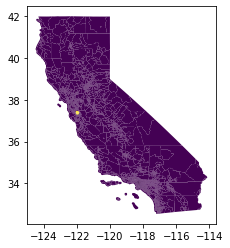

In [17]:
assignment = [ -1 for i in G.nodes ]
labeling = { i : 1 if x[i].x > 0.5 else 0 for i in G.nodes }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()

In [18]:
county_geoids = { G.nodes[i]['GEOID20'][0:5] for i in G.nodes }
county_pop = { g : 0 for g in county_geoids }

In [19]:
for i in labeling.keys():
    if labeling[i]==1:
        g = G.nodes[i]['GEOID20'][0:5]
        p = G.nodes[i]['TOTPOP']
        county_pop[g] += p

In [20]:
count = 0
print("geoid pop total_pop county")
for g in county_pop.keys():
    if county_pop[g]>0:
        i = gtn[g]
        print(g,county_pop[g],GC.nodes[i]['TOTPOP'],GC.nodes[i]['NAME20'],100*county_pop[g]/GC.nodes[i]['TOTPOP'])
        count += 1
print(count)

geoid pop total_pop county
06085 762459 1936259 Santa Clara 39.37794478941092
1


In [21]:
nx.is_connected(G.subgraph(district))

True